In [1]:
!pip install jovian --upgrade --quiet
import jovian
project_name='landscape-final' # will be used by jovian.commit

<IPython.core.display.Javascript object>

In [2]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Look into the data directory
data_dir = '../input/intel-image-classification/'
print(os.listdir(data_dir))

['seg_test', 'seg_pred', 'seg_train']


In [4]:
train_tfms = tt.Compose([
    tt.Resize((150, 150)),
    tt.RandomHorizontalFlip(),
    tt.ToTensor(),
#     tt.RandomErasing(inplace=True),
#     tt.Normalize((0.4332263 , 0.4585635 , 0.45523438), (0.237158  , 0.23522326, 0.24391426))
])

valid_tfms = tt.Compose([
    tt.Resize((150, 150)),
    tt.ToTensor(),
#     tt.Normalize((0.4332263 , 0.4585635 , 0.45523438), (0.237158  , 0.23522326, 0.24391426))
])

In [5]:
# PyTorch datasets
train_ds = ImageFolder(data_dir+'/seg_train/seg_train', train_tfms)
valid_ds = ImageFolder(data_dir+'/seg_test/seg_test', valid_tfms)
len(train_ds),len(valid_ds)

(14034, 3000)

In [6]:
batch_size = 64

In [7]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

In [8]:
from tqdm import tqdm
no_of_images = 0
mean = 0.
std = 0.
for batch, _ in tqdm(train_dl):
    # Rearrange batch to be the shape of [batch_size, no_of_channels, width_of_image * height_of_image]
    batch = batch.view(batch.size(0), batch.size(1), -1)
    
    # Update total number of images
    no_of_images += batch.size(0)
    
    # Compute mean and std here
    mean += batch.mean(2).sum(0) 
    std += batch.std(2).sum(0)


mean /= no_of_images
std /= no_of_images

print("Total number of images :", no_of_images," where Mean of images across channels: ", mean , "and std of images across channels: " , std)



100%|██████████| 220/220 [00:43<00:00,  5.03it/s]


Total number of images : 14034  where Mean of images across channels:  tensor([0.4302, 0.4575, 0.4539]) and std of images across channels:  tensor([0.2361, 0.2347, 0.2432])


In [9]:
# Get the classes
import pathlib
root = pathlib.Path('../input/intel-image-classification/seg_train/seg_train')
classes = sorted([j.name.split('/')[-1] for j in root.iterdir()])
print(classes)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [10]:
buildings_files = os.listdir(data_dir + "/seg_train/seg_train/buildings")
print('No. of training examples for buildings:', len(buildings_files))

forest_files = os.listdir(data_dir + "/seg_train/seg_train/forest")
print('No. of training examples for forests:', len(forest_files))

glacier_files = os.listdir(data_dir + "/seg_train/seg_train/glacier")
print('No. of training examples for glaciers:', len(glacier_files))

mountain_files = os.listdir(data_dir + "/seg_train/seg_train/mountain")
print('No. of training examples for mountains:', len(mountain_files))

sea_files = os.listdir(data_dir + "/seg_train/seg_train/sea")
print('No. of training examples for seas:', len(sea_files))

street_files = os.listdir(data_dir + "/seg_train/seg_train/street")
print('No. of training examples for streets:', len(street_files))

No. of training examples for buildings: 2191
No. of training examples for forests: 2271
No. of training examples for glaciers: 2404
No. of training examples for mountains: 2512
No. of training examples for seas: 2274
No. of training examples for streets: 2382


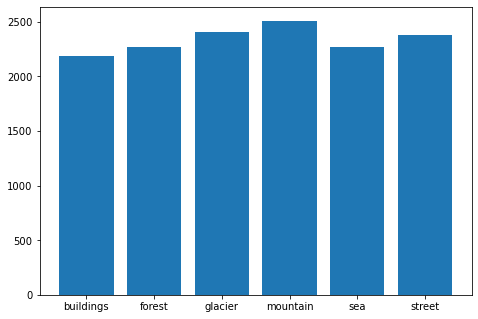

In [11]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
landscapes = [len(buildings_files),len(forest_files),len(glacier_files),len(mountain_files),len(sea_files),len(street_files)]
ax.bar(classes,landscapes)
plt.show()

As we can see, the data is pretty balanced

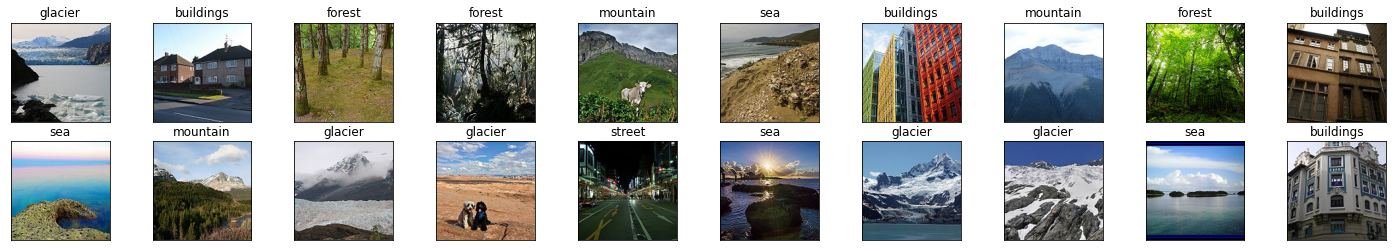

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img):
  '''
  Function to un-normalize and display an image
  '''
#   img = img/2 + 0.5 # un-normalize
  plt.imshow(np.transpose(img, (1, 2, 0))) # convert from tensor image
  
# Get a batch of training images
dataiter = iter(train_dl)
images, labels = next(dataiter)
images = images.cpu().data.numpy() # convert images to numpy for display

# Plot the images from the batch, along with corresponding labels
fig = plt.figure(figsize = (25, 4))

# Display 20 images
for idx in np.arange(20):
  ax = fig.add_subplot(2, 20/2, idx+1, xticks = [], yticks = [])
  imshow(images[idx])
  ax.set_title(classes[labels[idx]])

The images look at bit odd as the pixel values have been altered in the process of normalization.

In [13]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

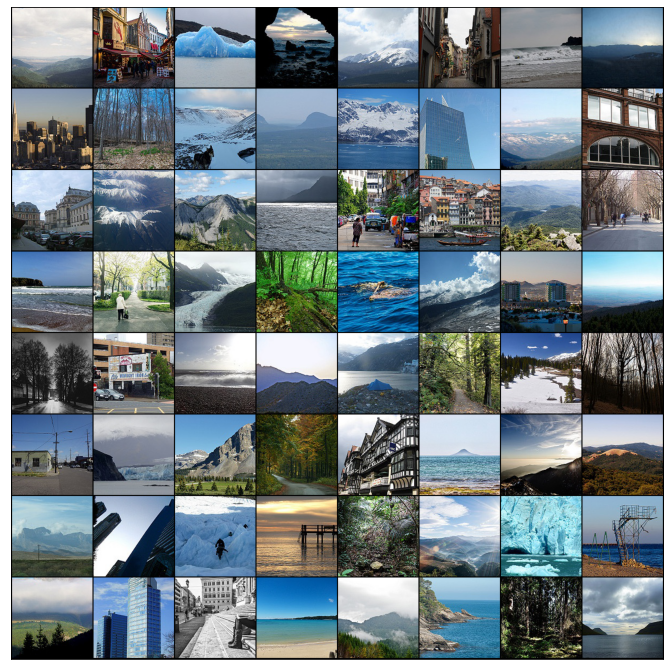

In [14]:
show_batch(train_dl)

In [15]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [16]:
device = get_default_device()
device

device(type='cuda')

In [17]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [18]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x # ReLU can be applied before or after adding the input

In [19]:
simple_resnet = to_device(SimpleResidualBlock(), device)

for images, labels in train_dl:
    out = simple_resnet(images)
    print(out.shape)
    break
    
del simple_resnet, images, labels
torch.cuda.empty_cache()

torch.Size([64, 3, 150, 150])


In [20]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [21]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Linear(8192, 6))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

class convNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(82944, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 6))
        
    def forward(self, xb):
        return self.network(xb)

In [22]:
model1 = to_device(ResNet9(3, 6), device)
# model1 = to_device(convNet(), device)
model1

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [23]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [24]:
history = [evaluate(model1, valid_dl)]
history

[{'val_loss': 1.7914152145385742, 'val_acc': 0.1438802033662796}]

In [25]:
epochs = 10
max_lr = 0.0005
grad_clip = 0.2
weight_decay = 1e-5
opt_func = torch.optim.Adam

In [26]:
%%time
history += fit_one_cycle(epochs, max_lr, model1, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

  0%|          | 0/220 [00:00<?, ?it/s]

Epoch [0], last_lr: 0.00014, train_loss: 0.8506, val_loss: 0.7673, val_acc: 0.7377


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch [1], last_lr: 0.00038, train_loss: 0.6697, val_loss: 0.7301, val_acc: 0.7424


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch [2], last_lr: 0.00050, train_loss: 0.6316, val_loss: 0.9914, val_acc: 0.6858


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch [3], last_lr: 0.00048, train_loss: 0.4915, val_loss: 0.6727, val_acc: 0.7996


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch [4], last_lr: 0.00041, train_loss: 0.4354, val_loss: 0.5718, val_acc: 0.8113


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch [5], last_lr: 0.00031, train_loss: 0.3666, val_loss: 0.4718, val_acc: 0.8377


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch [6], last_lr: 0.00019, train_loss: 0.3176, val_loss: 0.4049, val_acc: 0.8555


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch [7], last_lr: 0.00009, train_loss: 0.2295, val_loss: 0.3173, val_acc: 0.8892


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch [8], last_lr: 0.00002, train_loss: 0.1835, val_loss: 0.2827, val_acc: 0.9010


100%|██████████| 220/220 [01:15<00:00,  2.93it/s]


Epoch [9], last_lr: 0.00000, train_loss: 0.1504, val_loss: 0.2861, val_acc: 0.9013
CPU times: user 7min 10s, sys: 5min 26s, total: 12min 36s
Wall time: 13min 43s


In [ ]:
train_time='13:56'

In [27]:
def plot_scores(history):
    scores = [x['val_acc'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('Accuracy vs. No. of epochs'); 

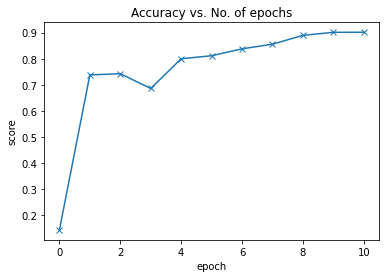

In [28]:
plot_scores(history)

In [29]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

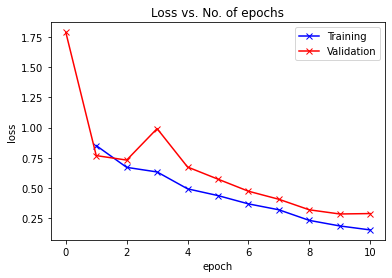

In [30]:
plot_losses(history)

In [31]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

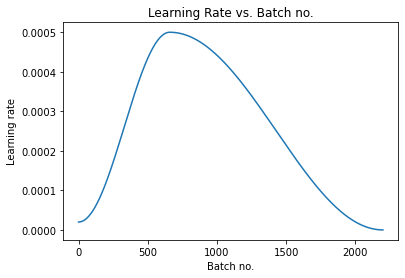

In [32]:
plot_lrs(history)

In [33]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

Normal ConvNet

In [42]:
model1 = to_device(convNet(), device)
model1

convNet(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten()
    (16): Linear(in_features=82944, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features=1024, out_features=512, b

In [43]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [44]:
history = [evaluate(model1, valid_dl)]
history

[{'val_loss': 1.7924402952194214, 'val_acc': 0.166015625}]

In [45]:
epochs = 20
max_lr = 0.0005
grad_clip = 0.2
weight_decay = 1e-5
opt_func = torch.optim.Adam

In [46]:
%%time
history += fit_one_cycle(epochs, max_lr, model1, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

  0%|          | 0/220 [00:00<?, ?it/s]

Epoch [0], last_lr: 0.00005, train_loss: 1.4043, val_loss: 1.0889, val_acc: 0.5705


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch [1], last_lr: 0.00014, train_loss: 0.9979, val_loss: 0.9595, val_acc: 0.6318


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch [2], last_lr: 0.00026, train_loss: 0.8998, val_loss: 0.8040, val_acc: 0.6998


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch [3], last_lr: 0.00038, train_loss: 0.7776, val_loss: 0.7778, val_acc: 0.6982


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch [4], last_lr: 0.00047, train_loss: 0.6806, val_loss: 0.6152, val_acc: 0.7824


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch [5], last_lr: 0.00050, train_loss: 0.5723, val_loss: 0.5538, val_acc: 0.8005


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch [6], last_lr: 0.00049, train_loss: 0.4713, val_loss: 0.4949, val_acc: 0.8229


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch [7], last_lr: 0.00048, train_loss: 0.4191, val_loss: 0.4906, val_acc: 0.8261


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch [8], last_lr: 0.00045, train_loss: 0.3545, val_loss: 0.4925, val_acc: 0.8282


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch [9], last_lr: 0.00041, train_loss: 0.3068, val_loss: 0.4627, val_acc: 0.8464


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch [10], last_lr: 0.00036, train_loss: 0.2533, val_loss: 0.4412, val_acc: 0.8517


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch [11], last_lr: 0.00031, train_loss: 0.1990, val_loss: 0.4574, val_acc: 0.8550


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch [12], last_lr: 0.00025, train_loss: 0.1448, val_loss: 0.5134, val_acc: 0.8602


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch [13], last_lr: 0.00019, train_loss: 0.0968, val_loss: 0.5487, val_acc: 0.8571


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch [14], last_lr: 0.00014, train_loss: 0.0644, val_loss: 0.5998, val_acc: 0.8540


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch [15], last_lr: 0.00009, train_loss: 0.0398, val_loss: 0.6806, val_acc: 0.8588


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch [16], last_lr: 0.00005, train_loss: 0.0243, val_loss: 0.7335, val_acc: 0.8546


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch [17], last_lr: 0.00002, train_loss: 0.0149, val_loss: 0.7621, val_acc: 0.8639


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch [18], last_lr: 0.00001, train_loss: 0.0104, val_loss: 0.7838, val_acc: 0.8646


100%|██████████| 220/220 [00:34<00:00,  6.30it/s]


Epoch [19], last_lr: 0.00000, train_loss: 0.0091, val_loss: 0.7857, val_acc: 0.8656
CPU times: user 4min 56s, sys: 3min 27s, total: 8min 24s
Wall time: 13min 35s


In [47]:
def plot_scores(history):
    scores = [x['val_acc'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('Accuracy vs. No. of epochs'); 

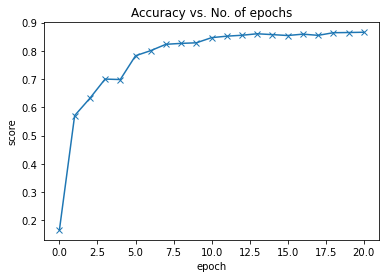

In [48]:
plot_scores(history)

In [49]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

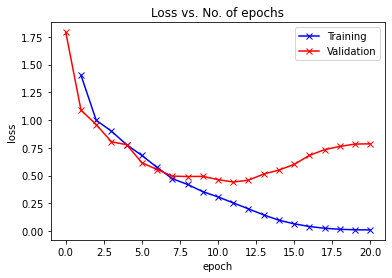

In [50]:
plot_losses(history)

In [51]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

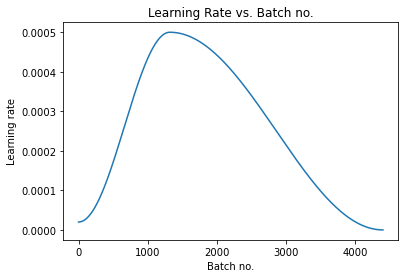

In [52]:
plot_lrs(history)

**Transfer Learning**

VGG19 

In [53]:
# import torchvision
import torchvision.models as models
model2 = models.vgg19(pretrained=True).to(device)
for param in model2.features.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth


In [55]:
model2.classifier[6] = nn.Linear(model2.classifier[6].in_features, len(classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.classifier.parameters(), lr=0.0005)

In [56]:
model2

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [57]:
trainlosses = []
testlosses = []
for e in range(20):
    trainloss = 0
    traintotal = 0
    trainsuccessful = 0
    for traininput, trainlabel in tqdm(train_dl):
        traininputs, trainlabels = traininput.to(device), trainlabel.to(device)
        optimizer.zero_grad()
        trainpredictions = model2(traininputs)
        _, trainpredict = torch.max(trainpredictions.data, 1)
        loss = criterion(trainpredictions, trainlabels)
        loss.backward()
        optimizer.step()
        trainloss += loss.item()
        traintotal += trainlabels.size(0)
        trainsuccessful += (trainpredict == trainlabels).sum().item()
    else:
        testloss = 0
        testtotal = 0
        testsuccessful = 0
        with torch.no_grad():
            for testinput, testlabel in tqdm(valid_dl):
                testinputs, testlabels = testinput.to(device), testlabel.to(device)
                testpredictions = model2(testinputs)
                _, testpredict = torch.max(testpredictions.data, 1)
                tloss = criterion(testpredictions, testlabels)
                testloss += tloss.item()
                testtotal += testlabels.size(0)
                testsuccessful += (testpredict == testlabels).sum().item()
        trainlosses.append(trainloss/len(train_dl))
        testlosses.append(testloss/len(valid_dl))
        print('Epoch :',e)
        print('Train Accuracy %{:.2f}'.format(100*trainsuccessful/traintotal))
        print('Test Accuracy %{:.2f}'.format(100*testsuccessful/testtotal))

  0%|          | 0/220 [00:00<?, ?it/s]

Epoch : 0
Train Accuracy %85.09
Test Accuracy %86.63


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch : 1
Train Accuracy %89.10
Test Accuracy %86.47


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch : 2
Train Accuracy %89.58
Test Accuracy %88.17


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch : 3
Train Accuracy %90.59
Test Accuracy %87.50


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch : 4
Train Accuracy %91.56
Test Accuracy %88.63


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch : 5
Train Accuracy %91.93
Test Accuracy %90.40


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch : 6
Train Accuracy %91.98
Test Accuracy %89.87


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch : 7
Train Accuracy %93.10
Test Accuracy %89.33


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch : 8
Train Accuracy %92.45
Test Accuracy %89.53


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch : 9
Train Accuracy %92.85
Test Accuracy %89.83


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch : 10
Train Accuracy %93.25
Test Accuracy %89.57


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch : 11
Train Accuracy %93.86
Test Accuracy %89.23


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch : 12
Train Accuracy %93.82
Test Accuracy %88.40


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch : 13
Train Accuracy %94.41
Test Accuracy %89.50


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch : 14
Train Accuracy %94.90
Test Accuracy %90.20


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch : 15
Train Accuracy %94.94
Test Accuracy %88.63


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch : 16
Train Accuracy %95.00
Test Accuracy %88.97


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch : 17
Train Accuracy %95.31
Test Accuracy %89.00


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch : 18
Train Accuracy %95.51
Test Accuracy %89.83


100%|██████████| 24/24 [00:07<00:00,  3.39it/s]

Epoch : 19
Train Accuracy %95.55
Test Accuracy %89.77


Resnet18

In [64]:
# import torchvision
import torchvision.models as models
model3 = models.resnet18(pretrained=True).to(device)
# for param in model3.features.parameters():
#     param.requires_grad = False

In [65]:
model3.fc = nn.Linear(512, len(classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model3.fc.parameters(), lr=0.005)
model3

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [66]:
trainlosses = []
testlosses = []
for e in range(10):
    trainloss = 0
    traintotal = 0
    trainsuccessful = 0
    for traininput, trainlabel in tqdm(train_dl):
        traininputs, trainlabels = traininput.to(device), trainlabel.to(device)
        optimizer.zero_grad()
        trainpredictions = model3(traininputs)
        _, trainpredict = torch.max(trainpredictions.data, 1)
        loss = criterion(trainpredictions, trainlabels)
        loss.backward()
        optimizer.step()
        trainloss += loss.item()
        traintotal += trainlabels.size(0)
        trainsuccessful += (trainpredict == trainlabels).sum().item()
    else:
        testloss = 0
        testtotal = 0
        testsuccessful = 0
        with torch.no_grad():
            for testinput, testlabel in tqdm(valid_dl):
                testinputs, testlabels = testinput.to(device), testlabel.to(device)
                testpredictions = model3(testinputs)
                _, testpredict = torch.max(testpredictions.data, 1)
                tloss = criterion(testpredictions, testlabels)
                testloss += tloss.item()
                testtotal += testlabels.size(0)
                testsuccessful += (testpredict == testlabels).sum().item()
        trainlosses.append(trainloss/len(train_dl))
        testlosses.append(testloss/len(valid_dl))
        print('Epoch: ', e)
        print('Train Accuracy %{:.2f}'.format(100*trainsuccessful/traintotal))
        print('Test Accuracy %{:.2f}'.format(100*testsuccessful/testtotal))

  0%|          | 0/220 [00:00<?, ?it/s]

Epoch:  0
Train Accuracy %83.55
Test Accuracy %24.47


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch:  1
Train Accuracy %87.89
Test Accuracy %24.80


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch:  2
Train Accuracy %87.89
Test Accuracy %26.03


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch:  3
Train Accuracy %88.00
Test Accuracy %24.40


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch:  4
Train Accuracy %88.56
Test Accuracy %23.40


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch:  5
Train Accuracy %88.20
Test Accuracy %25.50


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch:  6
Train Accuracy %88.42
Test Accuracy %25.87


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch:  7
Train Accuracy %88.64
Test Accuracy %25.40


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch:  8
Train Accuracy %88.69
Test Accuracy %25.60


100%|██████████| 24/24 [00:05<00:00,  4.30it/s]

Epoch:  9
Train Accuracy %88.44
Test Accuracy %26.00


Googlenet

In [67]:
# import torchvision
import torchvision.models as models
model4 = models.googlenet(pretrained=True).to(device)
for param in model4.parameters():
    param.requires_grad = False
for param in model4.fc.parameters():
    param.requires_grad = True
model4

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/checkpoints/googlenet-1378be20.pth


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [71]:
model4.fc.out_features = 6
model4.to(device)
# model2.classifier[6] = nn.Linear(model2.classifier[6].in_features, len(classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model4.fc.parameters(), lr=0.005)

In [72]:
trainlosses = []
testlosses = []
for e in range(20):
    trainloss = 0
    traintotal = 0
    trainsuccessful = 0
    for traininput, trainlabel in tqdm(train_dl):
        traininputs, trainlabels = traininput.to(device), trainlabel.to(device)
        optimizer.zero_grad()
        trainpredictions = model4(traininputs)
        _, trainpredict = torch.max(trainpredictions.data, 1)
        loss = criterion(trainpredictions, trainlabels)
        loss.backward()
        optimizer.step()
        trainloss += loss.item()
        traintotal += trainlabels.size(0)
        trainsuccessful += (trainpredict == trainlabels).sum().item()
    else:
        testloss = 0
        testtotal = 0
        testsuccessful = 0
        with torch.no_grad():
            for testinput, testlabel in tqdm(valid_dl):
                testinputs, testlabels = testinput.to(device), testlabel.to(device)
                testpredictions = model4(testinputs)
                _, testpredict = torch.max(testpredictions.data, 1)
                tloss = criterion(testpredictions, testlabels)
                testloss += tloss.item()
                testtotal += testlabels.size(0)
                testsuccessful += (testpredict == testlabels).sum().item()
        trainlosses.append(trainloss/len(train_dl))
        testlosses.append(testloss/len(valid_dl))
        print('Epoch :',e)
        print('Train Accuracy %{:.2f}'.format(100*trainsuccessful/traintotal))
        print('Test Accuracy %{:.2f}'.format(100*testsuccessful/testtotal))

  0%|          | 0/220 [00:00<?, ?it/s]

Epoch : 0
Train Accuracy %76.86
Test Accuracy %24.47


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch : 1
Train Accuracy %84.40
Test Accuracy %24.23


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch : 2
Train Accuracy %84.93
Test Accuracy %24.87


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch : 3
Train Accuracy %84.63
Test Accuracy %24.47


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch : 4
Train Accuracy %85.06
Test Accuracy %22.80


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch : 5
Train Accuracy %85.06
Test Accuracy %25.37


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch : 6
Train Accuracy %85.56
Test Accuracy %24.23


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch : 7
Train Accuracy %85.91
Test Accuracy %24.17


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch : 8
Train Accuracy %85.26
Test Accuracy %24.87


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch : 9
Train Accuracy %85.28
Test Accuracy %24.87


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch : 10
Train Accuracy %85.61
Test Accuracy %25.07


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch : 11
Train Accuracy %85.54
Test Accuracy %24.57


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch : 12
Train Accuracy %85.54
Test Accuracy %24.30


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch : 13
Train Accuracy %85.68
Test Accuracy %24.47


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch : 14
Train Accuracy %85.35
Test Accuracy %23.27


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch : 15
Train Accuracy %85.28
Test Accuracy %24.57


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch : 16
Train Accuracy %85.83
Test Accuracy %25.27


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch : 17
Train Accuracy %85.84
Test Accuracy %25.90


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch : 18
Train Accuracy %85.77
Test Accuracy %25.40


100%|██████████| 24/24 [00:05<00:00,  4.31it/s]

Epoch : 19
Train Accuracy %85.40
Test Accuracy %24.53


In [74]:
# import torchvision
import torchvision.models as models
model5 = models.mobilenet_v2(pretrained=True).to(device)
for param in model2.features.parameters():
    param.requires_grad = False

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [75]:
model5.classifier[1].out_features = 6
model5.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model5.classifier.parameters(), lr=0.0005)
model5

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [76]:
trainlosses = []
testlosses = []
for e in range(10):
    trainloss = 0
    traintotal = 0
    trainsuccessful = 0
    for traininput, trainlabel in tqdm(train_dl):
        traininputs, trainlabels = traininput.to(device), trainlabel.to(device)
        optimizer.zero_grad()
        trainpredictions = model5(traininputs)
        _, trainpredict = torch.max(trainpredictions.data, 1)
        loss = criterion(trainpredictions, trainlabels)
        loss.backward()
        optimizer.step()
        trainloss += loss.item()
        traintotal += trainlabels.size(0)
        trainsuccessful += (trainpredict == trainlabels).sum().item()
    else:
        testloss = 0
        testtotal = 0
        testsuccessful = 0
        with torch.no_grad():
            for testinput, testlabel in tqdm(valid_dl):
                testinputs, testlabels = testinput.to(device), testlabel.to(device)
                testpredictions = model5(testinputs)
                _, testpredict = torch.max(testpredictions.data, 1)
                tloss = criterion(testpredictions, testlabels)
                testloss += tloss.item()
                testtotal += testlabels.size(0)
                testsuccessful += (testpredict == testlabels).sum().item()
        trainlosses.append(trainloss/len(train_dl))
        testlosses.append(testloss/len(valid_dl))
        print('Epoch: ', e)
        print('Train Accuracy %{:.2f}'.format(100*trainsuccessful/traintotal))
        print('Test Accuracy %{:.2f}'.format(100*testsuccessful/testtotal))

  0%|          | 0/220 [00:00<?, ?it/s]

Epoch:  0
Train Accuracy %52.85
Test Accuracy %23.27


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch:  1
Train Accuracy %80.60
Test Accuracy %24.37


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch:  2
Train Accuracy %84.48
Test Accuracy %25.00


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch:  3
Train Accuracy %86.44
Test Accuracy %25.30


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch:  4
Train Accuracy %87.20
Test Accuracy %25.30


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch:  5
Train Accuracy %88.01
Test Accuracy %26.47


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch:  6
Train Accuracy %87.81
Test Accuracy %25.83


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch:  7
Train Accuracy %87.99
Test Accuracy %24.90


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch:  8
Train Accuracy %88.72
Test Accuracy %25.23


100%|██████████| 24/24 [00:05<00:00,  4.50it/s]

Epoch:  9
Train Accuracy %88.83
Test Accuracy %26.40


In [77]:
# import torchvision
import torchvision.models as models
model6 = models.alexnet(pretrained=True).to(device)
for param in model6.features.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth


In [78]:
model6.classifier[6].out_features = 6
model6.to(device)
# # model2.classifier[6] = nn.Linear(model2.classifier[6].in_features, len(classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model6.classifier.parameters(), lr=0.00001)
model6

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [79]:
trainlosses = []
testlosses = []
for e in range(15):
    trainloss = 0
    traintotal = 0
    trainsuccessful = 0
    for traininput, trainlabel in tqdm(train_dl):
        traininputs, trainlabels = traininput.to(device), trainlabel.to(device)
        optimizer.zero_grad()
        trainpredictions = model6(traininputs)
        _, trainpredict = torch.max(trainpredictions.data, 1)
        loss = criterion(trainpredictions, trainlabels)
        loss.backward()
        optimizer.step()
        trainloss += loss.item()
        traintotal += trainlabels.size(0)
        trainsuccessful += (trainpredict == trainlabels).sum().item()
    else:
        testloss = 0
        testtotal = 0
        testsuccessful = 0
        with torch.no_grad():
            for testinput, testlabel in tqdm(valid_dl):
                testinputs, testlabels = testinput.to(device), testlabel.to(device)
                testpredictions = model6(testinputs)
                _, testpredict = torch.max(testpredictions.data, 1)
                tloss = criterion(testpredictions, testlabels)
                testloss += tloss.item()
                testtotal += testlabels.size(0)
                testsuccessful += (testpredict == testlabels).sum().item()
        trainlosses.append(trainloss/len(train_dl))
        testlosses.append(testloss/len(valid_dl))
        print('Epoch: ',e)
        print('Train Accuracy %{:.2f}'.format(100*trainsuccessful/traintotal))
        print('Test Accuracy %{:.2f}'.format(100*testsuccessful/testtotal))

  0%|          | 0/220 [00:00<?, ?it/s]

Epoch:  0
Train Accuracy %57.79
Test Accuracy %78.20


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch:  1
Train Accuracy %80.85
Test Accuracy %81.63


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch:  2
Train Accuracy %83.59
Test Accuracy %82.20


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch:  3
Train Accuracy %84.46
Test Accuracy %83.87


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch:  4
Train Accuracy %85.70
Test Accuracy %85.33


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch:  5
Train Accuracy %86.55
Test Accuracy %85.50


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch:  6
Train Accuracy %87.19
Test Accuracy %85.27


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch:  7
Train Accuracy %87.60
Test Accuracy %85.73


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch:  8
Train Accuracy %88.14
Test Accuracy %85.67


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch:  9
Train Accuracy %88.67
Test Accuracy %86.37


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch:  10
Train Accuracy %89.19
Test Accuracy %86.20


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch:  11
Train Accuracy %89.39
Test Accuracy %86.90


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch:  12
Train Accuracy %89.39
Test Accuracy %86.43


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch:  13
Train Accuracy %90.05
Test Accuracy %86.20


100%|██████████| 24/24 [00:05<00:00,  4.58it/s]

Epoch:  14
Train Accuracy %90.54
Test Accuracy %87.33


In [ ]:
# import torchvision
import torchvision.models as models
model8 = models.vgg11_bn(pretrained=True).to(device)
for param in model8.features.parameters():
    param.requires_grad = False

In [ ]:
model8.classifier[6] = nn.Linear(model2.classifier[6].in_features, len(classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model8.classifier.parameters(), lr=0.00001)
model8

In [ ]:
trainlosses = []
testlosses = []
for e in range(20):
    trainloss = 0
    traintotal = 0
    trainsuccessful = 0
    for traininput, trainlabel in tqdm(train_dl):
        traininputs, trainlabels = traininput.to(device), trainlabel.to(device)
        optimizer.zero_grad()
        trainpredictions = model8(traininputs)
        _, trainpredict = torch.max(trainpredictions.data, 1)
        loss = criterion(trainpredictions, trainlabels)
        loss.backward()
        optimizer.step()
        trainloss += loss.item()
        traintotal += trainlabels.size(0)
        trainsuccessful += (trainpredict == trainlabels).sum().item()
    else:
        testloss = 0
        testtotal = 0
        testsuccessful = 0
        with torch.no_grad():
            for testinput, testlabel in tqdm(valid_dl):
                testinputs, testlabels = testinput.to(device), testlabel.to(device)
                testpredictions = model8(testinputs)
                _, testpredict = torch.max(testpredictions.data, 1)
                tloss = criterion(testpredictions, testlabels)
                testloss += tloss.item()
                testtotal += testlabels.size(0)
                testsuccessful += (testpredict == testlabels).sum().item()
        trainlosses.append(trainloss/len(train_dl))
        testlosses.append(testloss/len(valid_dl))
        print('Epoch: ',e)
        print('Train Accuracy %{:.2f}'.format(100*trainsuccessful/traintotal))
        print('Test Accuracy %{:.2f}'.format(100*testsuccessful/testtotal))

In [20]:
# import torchvision
import torchvision.models as models
model9 = models.resnet34(pretrained=True).to(device)
for param in model9.parameters():
    param.requires_grad = False
model9

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [23]:
model9.fc = nn.Linear(512,6).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model9.fc.parameters(), lr=0.00001)
model9

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [25]:
from tqdm import tqdm
trainlosses = []
testlosses = []
for e in range(10):
    trainloss = 0
    traintotal = 0
    trainsuccessful = 0
    for traininput, trainlabel in tqdm(train_dl):
        traininputs, trainlabels = traininput.to(device), trainlabel.to(device)
        optimizer.zero_grad()
        trainpredictions = model9(traininputs)
        _, trainpredict = torch.max(trainpredictions.data, 1)
        loss = criterion(trainpredictions, trainlabels)
        loss.backward()
        optimizer.step()
        trainloss += loss.item()
        traintotal += trainlabels.size(0)
        trainsuccessful += (trainpredict == trainlabels).sum().item()
    else:
        testloss = 0
        testtotal = 0
        testsuccessful = 0
        with torch.no_grad():
            for testinput, testlabel in tqdm(valid_dl):
                testinputs, testlabels = testinput.to(device), testlabel.to(device)
                testpredictions = model9(testinputs)
                _, testpredict = torch.max(testpredictions.data, 1)
                tloss = criterion(testpredictions, testlabels)
                testloss += tloss.item()
                testtotal += testlabels.size(0)
                testsuccessful += (testpredict == testlabels).sum().item()
        trainlosses.append(trainloss/len(train_dl))
        testlosses.append(testloss/len(valid_dl))
        print('Epoch: ',e)
        print('Train Accuracy %{:.2f}'.format(100*trainsuccessful/traintotal))
        print('Test Accuracy %{:.2f}'.format(100*testsuccessful/testtotal))

  0%|          | 0/220 [00:00<?, ?it/s]

Epoch:  0
Train Accuracy %16.33
Test Accuracy %17.17


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch:  1
Train Accuracy %22.99
Test Accuracy %18.17


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch:  2
Train Accuracy %30.81
Test Accuracy %18.67


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch:  3
Train Accuracy %38.28
Test Accuracy %19.40


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch:  4
Train Accuracy %45.80
Test Accuracy %19.93


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch:  5
Train Accuracy %52.52
Test Accuracy %20.63


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch:  6
Train Accuracy %56.90
Test Accuracy %21.63


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch:  7
Train Accuracy %62.02
Test Accuracy %22.23


  0%|          | 0/220 [00:00<?, ?it/s]

Epoch:  8
Train Accuracy %65.22
Test Accuracy %22.73


100%|██████████| 24/24 [00:06<00:00,  3.81it/s]

Epoch:  9
Train Accuracy %68.73
Test Accuracy %23.20


In [ ]:
jovian.log_metrics(train_loss=history[-1]['train_loss'], 
                   val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_acc'])

In [80]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Uploading notebook to https://jovian.ml/devbhartra/landscape-final


<IPython.core.display.Javascript object>